In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
import joblib

In [2]:
line = "="*50

In [3]:
df = pd.read_csv(r"datasets/Automobile_data.txt")
df.head().T

,0,1,2,3,4
symboling,3,3,1,2,2
normalized-losses,?,?,?,164,164
make,alfa-romero,alfa-romero,alfa-romero,audi,audi
fuel-type,gas,gas,gas,gas,gas
aspiration,std,std,std,std,std
num-of-doors,two,two,two,four,four
body-style,convertible,convertible,hatchback,sedan,sedan
drive-wheels,rwd,rwd,rwd,fwd,4wd
engine-location,front,front,front,front,front
wheel-base,88.6,88.6,94.5,99.8,99.4


Objectif : un modèle régression qui prédit le prix des voitures.

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 205 entries, 0 to 204
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   symboling          205 non-null    int64  
 1   normalized-losses  205 non-null    object 
 2   make               205 non-null    object 
 3   fuel-type          205 non-null    object 
 4   aspiration         205 non-null    object 
 5   num-of-doors       205 non-null    object 
 6   body-style         205 non-null    object 
 7   drive-wheels       205 non-null    object 
 8   engine-location    205 non-null    object 
 9   wheel-base         205 non-null    float64
 10  length             205 non-null    float64
 11  width              205 non-null    float64
 12  height             205 non-null    float64
 13  curb-weight        205 non-null    int64  
 14  engine-type        205 non-null    object 
 15  num-of-cylinders   205 non-null    object 
 16  engine-size        205 non

In [6]:
df.describe(exclude=['object']).T

,count,mean,std,min,25%,50%,75%,max
symboling,205.0,0.834146,1.245307,-2.0,0.0,1.0,2.0,3.0
wheel-base,205.0,98.756585,6.021776,86.6,94.5,97.0,102.4,120.9
length,205.0,174.049268,12.337289,141.1,166.3,173.2,183.1,208.1
width,205.0,65.907805,2.145204,60.3,64.1,65.5,66.9,72.3
height,205.0,53.724878,2.443522,47.8,52.0,54.1,55.5,59.8
curb-weight,205.0,2555.565854,520.680204,1488.0,2145.0,2414.0,2935.0,4066.0
engine-size,205.0,126.907317,41.642693,61.0,97.0,120.0,141.0,326.0
compression-ratio,205.0,10.142537,3.972040,7.0,8.6,9.0,9.4,23.0
city-mpg,205.0,25.219512,6.542142,13.0,19.0,24.0,30.0,49.0
highway-mpg,205.0,30.751220,6.886443,16.0,25.0,30.0,34.0,54.0


La variable d'interêt **price** n'est pas au format float et certaines variables quanti sont classées object (exp normalized-loss)

## Preprocessing

### a - Feature eng : 


In [7]:
n_for_test = 20
other = len(df) - n_for_test
train = df.iloc[:other]
test = df.iloc[:-n_for_test]

In [8]:
def quantitative_cleaner(data2):
    print(line,"\n\tQUANTITATIVES FEATURES\n",line)
    data = data2.copy()
    # recenser les variables (numeriques) a traiter : celles qui ont des valeurs manquantes
    cols_to_clean = []
    for col in data.columns : 
        k = data[col].loc[data[col] == '?'].count()
        if k != 0 :
            print('to clean :', col, data[col].dtype)
            cols_to_clean.append(col)
    
    # traitement : imputation par la médiane
    # remplacer les ? par la mediane (ne pas affecter la distro)
    # et convertir en float
    quantitative_imputation_errors = []
    for col in cols_to_clean :
        try : 
            v = data[col].loc[data[col] != '?']
            vmedian = v.astype(str).astype(float).median()
            data[col] = data[col].replace('?', vmedian).astype(float)
            print("-> numeric cleaned : ", col, data[col].dtype)
        except ValueError : # /!\ à améliorer => traiter le cas des non numériques
            quantitative_imputation_errors.append(col)
            # pour les variables qui n'ont pas pu etre imputées, supprimer le '?' et remplacer par NaN
            # data[col] = data[col].replace('?', )
    print("Quantitative_imputation_errors :\n", quantitative_imputation_errors, end ="\n\n") 
    
    return data

def qualitative_encoder(data2, columns_nominal, columns_ordinal):
    print(line,"\n\tQUALITATIVES FEATURES\n",line)
    data = data2.copy()
    # encodage nominal avec sklearn
    for col in columns_nominal :
        data[col] = LabelEncoder().fit_transform(data[col])
        print("-> encoded : ", col, data[col].dtype)
    # encodage ordinal : remplacer les lettres par des chiffres selon le dico suivant 
    numeric_dico ={
    'one': 1, 'two': 2, 'three': 3, 'four': 4, 'five': 5,
    'six': 6, 'seven': 7, 'eight': 8, 'nine': 9, 'ten': 10,
    'eleven': 11, 'twelve': 12, '?': 99
    }
    for col in columns_ordinal :
        data[col] = data[col].replace(numeric_dico).astype(int)
        print("-> encoded : ", col, data[col].dtype, end ="\n\n")
    return data

variables_quali_nomi = [
    'make',
    'fuel-type',
    'aspiration',
    'body-style',
    'drive-wheels',
    'engine-location',
    'engine-type',
    'fuel-system'
]    

variables_quali_ordi = [
    'num-of-doors',
    'num-of-cylinders'
]

def cleaner(df) :
    # execution
    df_1 = quantitative_cleaner(df)
    df_cleaned = qualitative_encoder(df_1, variables_quali_nomi, variables_quali_ordi)

    if len(df_cleaned.select_dtypes(exclude=['int', 'float']).columns) > 0 : 
        print("/!\ ALTERTE : NETTOYAGE NON COMPLET")
    return df_cleaned

### b - Splitting/Scaling 


In [9]:
target = 'price'
# apprentissage validation sets 
train_cleaned = cleaner(train)

X = train_cleaned.drop(target, axis=1)
y = train_cleaned[target]

# train test split
seed = 2309
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size=0.2, shuffle = True, random_state=seed)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

	QUANTITATIVES FEATURES
to clean : normalized-losses object
to clean : num-of-doors object
to clean : bore object
to clean : stroke object
to clean : horsepower object
to clean : peak-rpm object
to clean : price object
-> numeric cleaned :  normalized-losses float64
-> numeric cleaned :  bore float64
-> numeric cleaned :  stroke float64
-> numeric cleaned :  horsepower float64
-> numeric cleaned :  peak-rpm float64
-> numeric cleaned :  price float64
Quantitative_imputation_errors :
 ['num-of-doors']

	QUALITATIVES FEATURES
-> encoded :  make int32
-> encoded :  fuel-type int32
-> encoded :  aspiration int32
-> encoded :  body-style int32
-> encoded :  drive-wheels int32
-> encoded :  engine-location int32
-> encoded :  engine-type int32
-> encoded :  fuel-system int32
-> encoded :  num-of-doors int32

-> encoded :  num-of-cylinders int32

(148, 25) (37, 25) (148,) (37,)


### Model pipeline

In [10]:
# Modèle random forest 
rf_pipeline = make_pipeline(
    StandardScaler(), 
    RandomForestRegressor(random_state=seed)
    )
    
rf_pipeline.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=2309))])

In [13]:
def evaluate_model(model, rep = False):

    train_preds = model.predict(X_train)
    rmse_train = round(mean_squared_error(y_train, train_preds, squared=False), 3)

    test_preds = model.predict(X_test)
    rmse_test = round(mean_squared_error(y_test, test_preds, squared=False), 3)

    if rep :
        return rmse_train, rmse_test
    else : 
        print(line)
        print("Train error :",rmse_train) 
        print("Test error :", rmse_test)

# execution
print("\nA simple Random forest regressor with standard scaler")
evaluate_model(rf_pipeline)


A simple Random forest regressor with standard scaler
Train error : 1156.631
Test error : 2906.328


In [14]:
import warnings
warnings.filterwarnings('ignore')
param_rf = {
    'n_estimators' : [int(x) for x in np.linspace(10, 80, 10)], # nombre d'arbres dans la forêt 10 20 30 ..
    'max_depth' : [2, 4], # nombre max de niveaux dans un arbre 
    'min_samples_split' : [2, 3], # nombre min d'echantillons (bootstrap) necessaire au niveau d'un noeud pour juger de le spliter 
    'min_samples_leaf' : [1, 2], # nombre min de samples requis à chaque node 
    'max_features' : ['auto', 'sqrt'] # nombre de features à considérer auto = et sqrt = 
}

# La recherche d'hyperparamètres est effectuée par "Random Search" car plus efficace que la Grid Search à nombre d'itérations fixé.
# Le critère de sélection est la "MSE".

from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

rcv = RandomizedSearchCV(RandomForestRegressor(), 
                        param_distributions=param_rf, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs = 1,
                        random_state = seed)

gcv = GridSearchCV(RandomForestRegressor(), 
                        param_grid=param_rf, 
                        cv = 5, 
                        verbose = 1, 
                        n_jobs = 1)


rcv.fit(X_train, y_train)
gcv.fit(X_train, y_train)
print("RCV results : ", rcv.best_params_)
print("GCV results : ", gcv.best_params_)
joblib.dump(rcv.best_estimator_, "./models_backup/rcv_best_model.joblib")
joblib.dump(gcv.best_estimator_, "./models_backup/gcv_best_model.joblib")

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 160 candidates, totalling 800 fits
RCV results :  {'n_estimators': 41, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 'sqrt', 'max_depth': 4}
GCV results :  {'max_depth': 4, 'max_features': 'auto', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 17}


['./models_backup/gcv_best_model.joblib']

A decision tree split the dataset recursively using decision nodes unless we are left with pure leaf nodes. 
And it finds the best split by maximizing the entropy gains. If a datasample satisfies the condition at a decision 
node then it moves to the left child else it moves to the right. Finally it reaches a node where a class label is assigned
to it : a leaf. 

Decision trees is highly sensitive to training data which could result in high variance (low biais). So our model may fail to generalize. Multiple trees = forest.. (100)

sampling with replacement at each draw.. over the whole dataset.. called bootstrapping. (a same row can appear many times in a bootstrap sample).. we make 100 samples by default.. train a decision tree over each dataset.. not use all the features each time.. instead randomly select features subset an use only them for training.

after that, to make a prediction, use each decision tree and note down predictions and combine with voting classifier (aggregation : majority voting) or average for regression problem. 

bagging = bootstrapping + aggregation

randomness = booststrapping (get rid of sensitivity to training data) + random feature selection (to get rid of the correlation between decision trees)


####  -> RandomisedSearchCV for RFR tuning

for smaller datasets GridSearchCV aura un nuplet de parametres de meilleures qualité que RCV.
par contre il faut s'attendre au contraire pour les jdd larges pour lesquels RCV permet d'economiser des ressources.
GridSCV teste toutes les combinaisons de paramètres alors que RCV testera des nuplets de valeurs au hasard ce qui fera donc moins de calculs.  

In [15]:
rcv_best_rf = joblib.load("./models_backup/rcv_best_model.joblib")
gcv_best_rf = joblib.load("./models_backup/gcv_best_model.joblib")

print("\nBest Random forest RCV regressor w/o Standard Scaler")
evaluate_model(rcv_best_rf)
print("\nBest Random forest GCV regressor w/o Standard Scaler")
evaluate_model(gcv_best_rf)


Best Random forest RCV regressor w/o Standard Scaler
Train error : 1745.959
Test error : 2625.703

Best Random forest GCV regressor w/o Standard Scaler
Train error : 1832.174
Test error : 3000.714


Le résultat de l'évaluation des deux meilleurs modèles post CV montrent que GCV permet au modèle de mieux apprendre mais il fait en moyenne plus d'erreur lors de la phase de test contrairement au meilleur modèle de RCV. Toute fois les erruers moyennes des deux restent du même niveau sur ce test set. La différence est au niveau du temps d'exécution : GCV tourne plus longtemps que RCV. <u>Malgré cette contrainte, on va garder le modèle de RCV pour la suite.</u>

<module 'matplotlib.pyplot' from 'c:\\Users\\gbeno\\anaconda3\\envs\\car_pricing\\Lib\\site-packages\\matplotlib\\pyplot.py'>

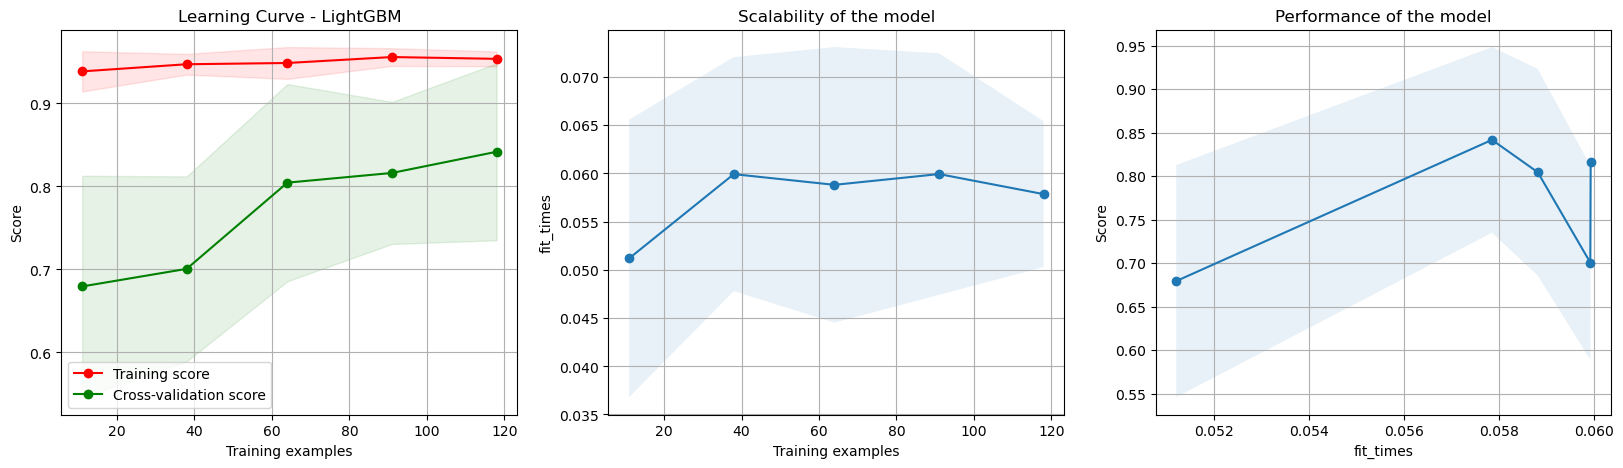

In [16]:
from utils import plot_learning_curve

estimator = gcv_best_rf
plot_learning_curve(
    estimator,
    title = "Learning Curve - LightGBM",
    X = X_train,
    y = y_train,
    cv=5,
    n_jobs=1,
)

La performance du modèle par validation croisée RCV augmente de moins en moins après 60 échantillons, ce qui laisse penser que la performance du modèle n'augmenterait plus beaucoup même si on avait accès à davantage de données d'entraînement.

#### Features Importance

In [18]:
print(estimator)
print(rf_pipeline)

RandomForestRegressor(max_depth=4, max_features='auto', min_samples_split=3,
                      n_estimators=17)
Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestregressor',
                 RandomForestRegressor(random_state=2309))])


In [19]:
rf_pipeline_cv = make_pipeline(
    StandardScaler(), 
    estimator
    )
    
rf_pipeline_cv.fit(X_train, y_train)
evaluate_model(rf_pipeline_cv)

Train error : 1700.405
Test error : 3218.844


In [20]:
model = rf_pipeline_cv
feature_names = model[:-1].get_feature_names_out()
mdi_importances = pd.Series(
                    model[-1].feature_importances_, index=feature_names
                            ).sort_values(ascending=True)

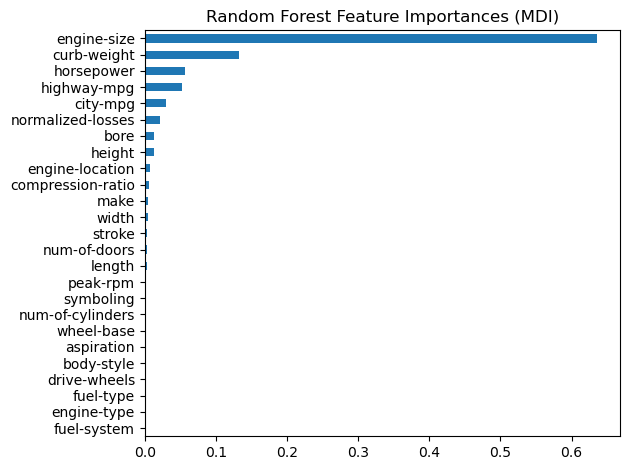

In [21]:
ax = mdi_importances.plot.barh()
ax.set_title("Random Forest Feature Importances (MDI)")
ax.figure.tight_layout()

Sauvegarde du modele final à envoyer sur streamlit

In [22]:
joblib.dump(rf_pipeline_cv, './models_backup/final_model.joblib')

['./models_backup/final_model.joblib']